In [125]:
# !pip install prophet
# !pip install plotly
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
p_ex_df = pd.read_csv('example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(p_ex_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.4685


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7976.11     0.0101103       286.068           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7993.56    0.00101134       304.061       0.582       0.582      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       7995.92   4.81029e-05       146.043   3.702e-07       0.001      353  LS failed, Hessian reset 
     299       7996.65   0.000581528       81.1695           1           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7999.51   0.000319467       223.369      0.5511      0.5511      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     465       8000.88   0.000146007       378.592   5.125e-07       0.001      6

In [5]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [9]:
# So there are basically 3 countries x 3 products x 2 stores = 18 series to predict.
df = pd.read_csv('train.csv')
countryList = list(df['country'].unique())
productList = list(df['product'].unique())
storeList = list(df['store'].unique())
print('Countries: ', countryList)
print('Products: ', productList)
print('Stores: ', storeList)

Countries:  ['Finland', 'Norway', 'Sweden']
Products:  ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']
Stores:  ['KaggleMart', 'KaggleRama']


In [10]:
df_prep = pd.get_dummies(df, columns=['country', 'product', 'store'])

In [11]:
df_prep.head()

,row_id,date,num_sold,country_Finland,country_Norway,country_Sweden,product_Kaggle Hat,product_Kaggle Mug,product_Kaggle Sticker,store_KaggleMart,store_KaggleRama
0,0,2015-01-01,329,1,0,0,0,1,0,1,0
1,1,2015-01-01,520,1,0,0,1,0,0,1,0
2,2,2015-01-01,146,1,0,0,0,0,1,1,0
3,3,2015-01-01,572,1,0,0,0,1,0,0,1
4,4,2015-01-01,911,1,0,0,1,0,0,0,1


In [12]:
df_prep.columns

Index(['row_id', 'date', 'num_sold', 'country_Finland', 'country_Norway',
       'country_Sweden', 'product_Kaggle Hat', 'product_Kaggle Mug',
       'product_Kaggle Sticker', 'store_KaggleMart', 'store_KaggleRama'],
      dtype='object')

In [21]:
# Generate dataframe for each series
df_dict = {}
for country in ['country_Finland', 'country_Norway', 'country_Sweden']:
    for product in ['product_Kaggle Hat', 'product_Kaggle Mug', 'product_Kaggle Sticker']:
        for store in ['store_KaggleMart', 'store_KaggleRama']:
            name = country.split('_')[1] + '_' + product.split('_')[1] + '_' + store.split('_')[1]
            currdf = df_prep[(df_prep[country] == 1) & (df_prep[product] == 1) & (df_prep[store] == 1)][['date', 'num_sold']]
            df_dict[name] = currdf

In [22]:
df_dict.keys()

dict_keys(['Finland_Kaggle Hat_KaggleMart', 'Finland_Kaggle Hat_KaggleRama', 'Finland_Kaggle Mug_KaggleMart', 'Finland_Kaggle Mug_KaggleRama', 'Finland_Kaggle Sticker_KaggleMart', 'Finland_Kaggle Sticker_KaggleRama', 'Norway_Kaggle Hat_KaggleMart', 'Norway_Kaggle Hat_KaggleRama', 'Norway_Kaggle Mug_KaggleMart', 'Norway_Kaggle Mug_KaggleRama', 'Norway_Kaggle Sticker_KaggleMart', 'Norway_Kaggle Sticker_KaggleRama', 'Sweden_Kaggle Hat_KaggleMart', 'Sweden_Kaggle Hat_KaggleRama', 'Sweden_Kaggle Mug_KaggleMart', 'Sweden_Kaggle Mug_KaggleRama', 'Sweden_Kaggle Sticker_KaggleMart', 'Sweden_Kaggle Sticker_KaggleRama'])

In [23]:
df_dict['Finland_Kaggle Hat_KaggleMart'].head()

,date,num_sold
1,2015-01-01,520
19,2015-01-02,493
37,2015-01-03,535
55,2015-01-04,544
73,2015-01-05,378


In [24]:
df.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [41]:
df_pivot = df.pivot_table('num_sold', ['date'], ['country', 'store', 'product'])

In [42]:
df_pivot.head()

country       Finland                                                  \
store      KaggleMart                           KaggleRama              
product    Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug   
date                                                                    
2015-01-01        520        329            146        911        572   
2015-01-02        493        318            127        794        544   
2015-01-03        535        360            141        843        579   
2015-01-04        544        332            125        873        582   
2015-01-05        378        243            102        668        423   

country                       Norway                                       \
store                     KaggleMart                           KaggleRama   
product    Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat   
date                                                                        
2015-01-01            283        906        526            250       1461   
2015-01-02            249        845        538            237       1446   
2015-01-03            265        930        614            254       1631   
2015-01-04            245        889        589            255       1540   
2015-01-05            187        671        435            184       1126   

country                                  Sweden                            \
store                                KaggleMart                             
product    Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker   
date                                                                        
2015-01-01       1005            395        624        440            175   
2015-01-02        949            415        572        384            155   
2015-01-03       1029            451        630        420            173   
2015-01-04        957            455        697        406            169   
2015-01-05        739            310        442        298            127   

country                                          
store      KaggleRama                            
product    Kaggle Hat Kaggle Mug Kaggle Sticker  
date                                             
2015-01-01       1195        706            324  
2015-01-02        986        653            293  
2015-01-03       1167        734            319  
2015-01-04       1112        657            300  
2015-01-05        796        512            227

In [43]:
df_pivot.columns = df_pivot.columns.map('_'.join).str.strip('_')

In [44]:
df_pivot.head()

,Finland_KaggleMart_Kaggle Hat,Finland_KaggleMart_Kaggle Mug,Finland_KaggleMart_Kaggle Sticker,Finland_KaggleRama_Kaggle Hat,Finland_KaggleRama_Kaggle Mug,Finland_KaggleRama_Kaggle Sticker,Norway_KaggleMart_Kaggle Hat,Norway_KaggleMart_Kaggle Mug,Norway_KaggleMart_Kaggle Sticker,Norway_KaggleRama_Kaggle Hat,Norway_KaggleRama_Kaggle Mug,Norway_KaggleRama_Kaggle Sticker,Sweden_KaggleMart_Kaggle Hat,Sweden_KaggleMart_Kaggle Mug,Sweden_KaggleMart_Kaggle Sticker,Sweden_KaggleRama_Kaggle Hat,Sweden_KaggleRama_Kaggle Mug,Sweden_KaggleRama_Kaggle Sticker
date,,,,,,,,,,,,,,,,,,
2015-01-01,520,329,146,911,572,283,906,526,250,1461,1005,395,624,440,175,1195,706,324
2015-01-02,493,318,127,794,544,249,845,538,237,1446,949,415,572,384,155,986,653,293
2015-01-03,535,360,141,843,579,265,930,614,254,1631,1029,451,630,420,173,1167,734,319
2015-01-04,544,332,125,873,582,245,889,589,255,1540,957,455,697,406,169,1112,657,300
2015-01-05,378,243,102,668,423,187,671,435,184,1126,739,310,442,298,127,796,512,227


In [34]:
df_pivot.tail()

,Finland_KaggleMart_Kaggle Hat,Finland_KaggleMart_Kaggle Mug,Finland_KaggleMart_Kaggle Sticker,Finland_KaggleRama_Kaggle Hat,Finland_KaggleRama_Kaggle Mug,Finland_KaggleRama_Kaggle Sticker,Norway_KaggleMart_Kaggle Hat,Norway_KaggleMart_Kaggle Mug,Norway_KaggleMart_Kaggle Sticker,Norway_KaggleRama_Kaggle Hat,Norway_KaggleRama_Kaggle Mug,Norway_KaggleRama_Kaggle Sticker,Sweden_KaggleMart_Kaggle Hat,Sweden_KaggleMart_Kaggle Mug,Sweden_KaggleMart_Kaggle Sticker,Sweden_KaggleRama_Kaggle Hat,Sweden_KaggleRama_Kaggle Mug,Sweden_KaggleRama_Kaggle Sticker
date,,,,,,,,,,,,,,,,,,
2018-12-27,573,414,177,1068,652,308,898,568,270,1604,1108,436,672,420,196,1127,745,319
2018-12-28,841,499,223,1398,895,431,1162,731,361,2178,1333,662,874,555,260,1540,990,441
2018-12-29,1107,774,296,1895,1398,559,1650,1113,518,2884,1816,874,1106,720,348,2169,1438,596
2018-12-30,1113,757,326,1878,1241,554,1809,1052,500,2851,1935,833,1133,730,336,2138,1303,587
2018-12-31,822,469,238,1231,831,360,1124,728,351,2128,1383,561,823,570,250,1441,1004,388


In [36]:
df_pivot.iloc[366]

Finland_KaggleMart_Kaggle Hat         524
Finland_KaggleMart_Kaggle Mug         316
Finland_KaggleMart_Kaggle Sticker     146
Finland_KaggleRama_Kaggle Hat        1020
Finland_KaggleRama_Kaggle Mug         648
Finland_KaggleRama_Kaggle Sticker     254
Norway_KaggleMart_Kaggle Hat          859
Norway_KaggleMart_Kaggle Mug          561
Norway_KaggleMart_Kaggle Sticker      228
Norway_KaggleRama_Kaggle Hat         1430
Norway_KaggleRama_Kaggle Mug          996
Norway_KaggleRama_Kaggle Sticker      436
Sweden_KaggleMart_Kaggle Hat          679
Sweden_KaggleMart_Kaggle Mug          428
Sweden_KaggleMart_Kaggle Sticker      183
Sweden_KaggleRama_Kaggle Hat         1210
Sweden_KaggleRama_Kaggle Mug          691
Sweden_KaggleRama_Kaggle Sticker      366
Name: 2016-01-02, dtype: int64

In [46]:
df_pivot.shape

(1461, 18)

In [67]:
df_target = df_pivot[['Finland_KaggleMart_Kaggle Hat']].iloc[0:-366]
df_target['ds'] = df_target.index
df_target['y'] = df_target['Finland_KaggleMart_Kaggle Hat']
df_target = df_target.reset_index()[['ds', 'y']]
df_target.head()

,ds,y
0,2015-01-01,520
1,2015-01-02,493
2,2015-01-03,535
3,2015-01-04,544
4,2015-01-05,378


In [77]:
df_prop = pd.concat([df_target, df_pivot.drop(['Finland_KaggleMart_Kaggle Hat'], axis=1).reset_index().iloc[0:-366]], axis=1)
df_prop.head()

,ds,y,date,Finland_KaggleMart_Kaggle Mug,Finland_KaggleMart_Kaggle Sticker,Finland_KaggleRama_Kaggle Hat,Finland_KaggleRama_Kaggle Mug,Finland_KaggleRama_Kaggle Sticker,Norway_KaggleMart_Kaggle Hat,Norway_KaggleMart_Kaggle Mug,Norway_KaggleMart_Kaggle Sticker,Norway_KaggleRama_Kaggle Hat,Norway_KaggleRama_Kaggle Mug,Norway_KaggleRama_Kaggle Sticker,Sweden_KaggleMart_Kaggle Hat,Sweden_KaggleMart_Kaggle Mug,Sweden_KaggleMart_Kaggle Sticker,Sweden_KaggleRama_Kaggle Hat,Sweden_KaggleRama_Kaggle Mug,Sweden_KaggleRama_Kaggle Sticker
0,2015-01-01,520,2015-01-01,329,146,911,572,283,906,526,250,1461,1005,395,624,440,175,1195,706,324
1,2015-01-02,493,2015-01-02,318,127,794,544,249,845,538,237,1446,949,415,572,384,155,986,653,293
2,2015-01-03,535,2015-01-03,360,141,843,579,265,930,614,254,1631,1029,451,630,420,173,1167,734,319
3,2015-01-04,544,2015-01-04,332,125,873,582,245,889,589,255,1540,957,455,697,406,169,1112,657,300
4,2015-01-05,378,2015-01-05,243,102,668,423,187,671,435,184,1126,739,310,442,298,127,796,512,227


In [ ]:
# Couldn't quite get the multi-variate to work properly, just predicting one column at a time using historic value, and see how well it does.
# https://stackoverflow.com/questions/54544285/is-it-possible-to-do-multivariate-multi-step-forecasting-using-fb-prophet

In [112]:
input_df = df_pivot.copy()
productLine = 'Finland_KaggleMart_Kaggle Hat'
m = Prophet()
df_target = input_df[[productLine]].iloc[0:-366]
df_target['ds'] = df_target.index
df_target['y'] = df_target[productLine]
df_target = df_target.reset_index()[['ds', 'y']]
df_target.head()
# df_prop = pd.concat([df_target, df_pivot.drop(['Finland_KaggleMart_Kaggle Hat'], axis=1).reset_index().iloc[0:-366]], axis=1)
# for column in input_df.columns:
#     if column in ['ds', 'y', 'date', productLine]:
#         print('Skipping column:' + column)
#         continue
#     else:
#         m.add_regressor(column)
m.fit(df_prop)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -114.361


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2964.59   0.000279383        214.61      0.4796      0.4796      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       2967.75   0.000344489       228.088    3.27e-06       0.001      280  LS failed, Hessian reset 
     199       2968.22   0.000606788       71.1424           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243        2968.5   0.000241492       112.144   3.319e-06       0.001      406  LS failed, Hessian reset 
     299       2968.63   4.18538e-06       33.8082           1           1      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       2968.63   1.28008e-07       39.5396      0.2103      0.6205      537   
Optimization terminated normally: 
  Convergence detected: rel

In [113]:
df_target.head()

,ds,y
0,2015-01-01,520
1,2015-01-02,493
2,2015-01-03,535
3,2015-01-04,544
4,2015-01-05,378


In [114]:
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1456,2018-12-27,529.121635,470.829758,586.719458
1457,2018-12-28,554.305313,497.988220,606.818107
1458,2018-12-29,623.736582,565.471334,680.565725
1459,2018-12-30,621.181578,563.454389,676.383890
1460,2018-12-31,545.042847,486.340230,601.555532


In [115]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,315.916829,383.111253,494.759562,315.916829,315.916829,122.768809,122.768809,122.768809,-24.416295,-24.416295,-24.416295,147.185104,147.185104,147.185104,0.0,0.0,0.0,438.685639
1,2015-01-02,315.983526,397.906428,512.248801,315.983526,315.983526,140.558580,140.558580,140.558580,-6.314054,-6.314054,-6.314054,146.872634,146.872634,146.872634,0.0,0.0,0.0,456.542107
2,2015-01-03,316.050223,460.861287,577.726230,316.050223,316.050223,202.488532,202.488532,202.488532,57.397934,57.397934,57.397934,145.090599,145.090599,145.090599,0.0,0.0,0.0,518.538756
3,2015-01-04,316.116920,450.820245,564.194774,316.116920,316.116920,192.458404,192.458404,192.458404,50.560474,50.560474,50.560474,141.897930,141.897930,141.897930,0.0,0.0,0.0,508.575324
4,2015-01-05,316.183617,365.609941,484.191036,316.183617,316.183617,109.003503,109.003503,109.003503,-28.375085,-28.375085,-28.375085,137.378589,137.378589,137.378589,0.0,0.0,0.0,425.187120


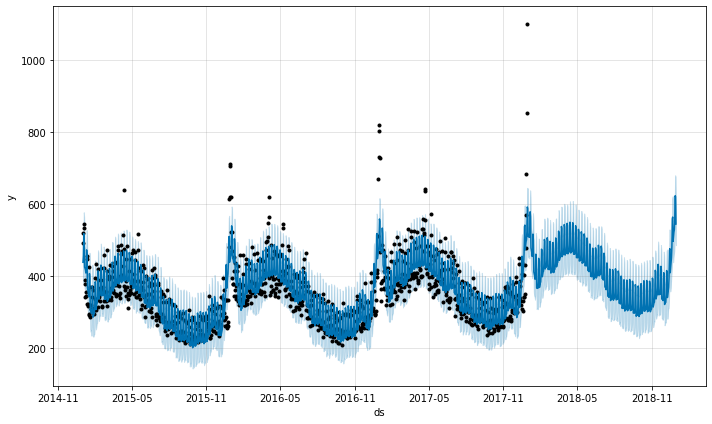

In [116]:
# Python
fig1 = m.plot(forecast)

In [120]:
df_compareError = forecast[['ds', 'yhat']]
df_compareError = pd.concat([df_compareError, df_pivot[['Finland_KaggleMart_Kaggle Hat']].reset_index()], axis=1)
                             

/apps/python3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='date'>

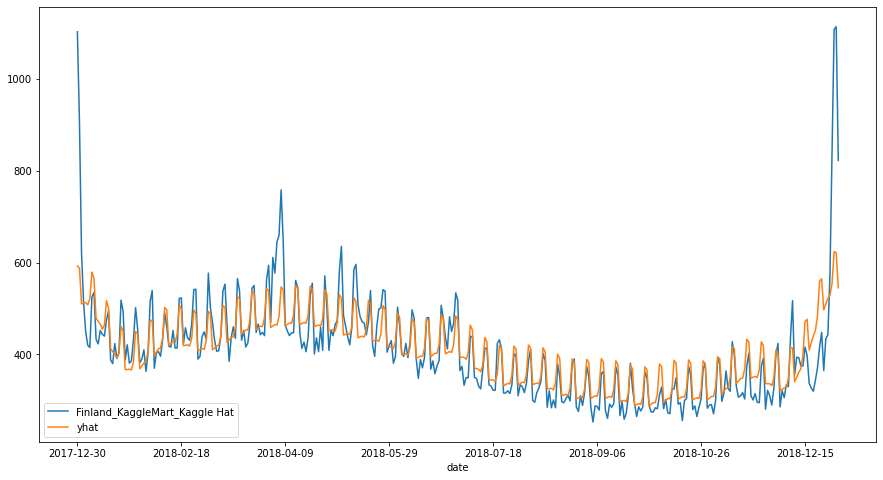

In [128]:
# fig = plt.figure()
df_compareError.iloc[-367:].plot(x='date', y=['Finland_KaggleMart_Kaggle Hat', 'yhat'], kind='line', figsize=(15,8))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Skipping column:Finland_KaggleMart_Kaggle Hat
Initial log joint probability = -114.361


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3923.2    0.00174506       3253.06      0.9808      0.9808      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3946.98    0.00210634       1025.71           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3954.58    0.00584002       566.801           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3957.55   0.000127603       254.713      0.9277      0.9277      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3959.57   6.29282e-05       185.422           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [100]:
future = m.make_future_dataframe(periods=366)

In [102]:
future.head()

,ds
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05


In [103]:
future.tail()

,ds
1456,2018-12-27
1457,2018-12-28
1458,2018-12-29
1459,2018-12-30
1460,2018-12-31


In [104]:
future.shape

(1461, 1)

In [105]:
df_pivot.shape

(1461, 18)

In [106]:
df_pivot.columns

Index(['Finland_KaggleMart_Kaggle Hat', 'Finland_KaggleMart_Kaggle Mug',
       'Finland_KaggleMart_Kaggle Sticker', 'Finland_KaggleRama_Kaggle Hat',
       'Finland_KaggleRama_Kaggle Mug', 'Finland_KaggleRama_Kaggle Sticker',
       'Norway_KaggleMart_Kaggle Hat', 'Norway_KaggleMart_Kaggle Mug',
       'Norway_KaggleMart_Kaggle Sticker', 'Norway_KaggleRama_Kaggle Hat',
       'Norway_KaggleRama_Kaggle Mug', 'Norway_KaggleRama_Kaggle Sticker',
       'Sweden_KaggleMart_Kaggle Hat', 'Sweden_KaggleMart_Kaggle Mug',
       'Sweden_KaggleMart_Kaggle Sticker', 'Sweden_KaggleRama_Kaggle Hat',
       'Sweden_KaggleRama_Kaggle Mug', 'Sweden_KaggleRama_Kaggle Sticker'],
      dtype='object')

In [109]:
future_withotherfeature = pd.concat([future, df_pivot[['Finland_KaggleMart_Kaggle Mug',
       'Finland_KaggleMart_Kaggle Sticker', 'Finland_KaggleRama_Kaggle Hat',
       'Finland_KaggleRama_Kaggle Mug', 'Finland_KaggleRama_Kaggle Sticker',
       'Norway_KaggleMart_Kaggle Hat', 'Norway_KaggleMart_Kaggle Mug',
       'Norway_KaggleMart_Kaggle Sticker', 'Norway_KaggleRama_Kaggle Hat',
       'Norway_KaggleRama_Kaggle Mug', 'Norway_KaggleRama_Kaggle Sticker',
       'Sweden_KaggleMart_Kaggle Hat', 'Sweden_KaggleMart_Kaggle Mug',
       'Sweden_KaggleMart_Kaggle Sticker', 'Sweden_KaggleRama_Kaggle Hat',
       'Sweden_KaggleRama_Kaggle Mug', 'Sweden_KaggleRama_Kaggle Sticker']].reset_index()], axis=1)
future_withotherfeature.head()

,ds,date,Finland_KaggleMart_Kaggle Mug,Finland_KaggleMart_Kaggle Sticker,Finland_KaggleRama_Kaggle Hat,Finland_KaggleRama_Kaggle Mug,Finland_KaggleRama_Kaggle Sticker,Norway_KaggleMart_Kaggle Hat,Norway_KaggleMart_Kaggle Mug,Norway_KaggleMart_Kaggle Sticker,Norway_KaggleRama_Kaggle Hat,Norway_KaggleRama_Kaggle Mug,Norway_KaggleRama_Kaggle Sticker,Sweden_KaggleMart_Kaggle Hat,Sweden_KaggleMart_Kaggle Mug,Sweden_KaggleMart_Kaggle Sticker,Sweden_KaggleRama_Kaggle Hat,Sweden_KaggleRama_Kaggle Mug,Sweden_KaggleRama_Kaggle Sticker
0,2015-01-01,2015-01-01,329,146,911,572,283,906,526,250,1461,1005,395,624,440,175,1195,706,324
1,2015-01-02,2015-01-02,318,127,794,544,249,845,538,237,1446,949,415,572,384,155,986,653,293
2,2015-01-03,2015-01-03,360,141,843,579,265,930,614,254,1631,1029,451,630,420,173,1167,734,319
3,2015-01-04,2015-01-04,332,125,873,582,245,889,589,255,1540,957,455,697,406,169,1112,657,300
4,2015-01-05,2015-01-05,243,102,668,423,187,671,435,184,1126,739,310,442,298,127,796,512,227


In [110]:
future_withotherfeature.tail()

,ds,date,Finland_KaggleMart_Kaggle Mug,Finland_KaggleMart_Kaggle Sticker,Finland_KaggleRama_Kaggle Hat,Finland_KaggleRama_Kaggle Mug,Finland_KaggleRama_Kaggle Sticker,Norway_KaggleMart_Kaggle Hat,Norway_KaggleMart_Kaggle Mug,Norway_KaggleMart_Kaggle Sticker,Norway_KaggleRama_Kaggle Hat,Norway_KaggleRama_Kaggle Mug,Norway_KaggleRama_Kaggle Sticker,Sweden_KaggleMart_Kaggle Hat,Sweden_KaggleMart_Kaggle Mug,Sweden_KaggleMart_Kaggle Sticker,Sweden_KaggleRama_Kaggle Hat,Sweden_KaggleRama_Kaggle Mug,Sweden_KaggleRama_Kaggle Sticker
1456,2018-12-27,2018-12-27,414,177,1068,652,308,898,568,270,1604,1108,436,672,420,196,1127,745,319
1457,2018-12-28,2018-12-28,499,223,1398,895,431,1162,731,361,2178,1333,662,874,555,260,1540,990,441
1458,2018-12-29,2018-12-29,774,296,1895,1398,559,1650,1113,518,2884,1816,874,1106,720,348,2169,1438,596
1459,2018-12-30,2018-12-30,757,326,1878,1241,554,1809,1052,500,2851,1935,833,1133,730,336,2138,1303,587
1460,2018-12-31,2018-12-31,469,238,1231,831,360,1124,728,351,2128,1383,561,823,570,250,1441,1004,388


In [111]:
forecast = m.predict(future)

ValueError: Regressor 'Finland_KaggleMart_Kaggle Mug' missing from dataframe

In [90]:
# This function takes in one country_product_store combo
def predictFuture(input_df, productLine):
    # The productLine is country_store_product, e.g. "Finland_KaggleMart_Kaggle Hat"
    # We will use that column as targetLabe, and then predict the year 2018, and then check the error.
    m = Prophet()
    df_target = input_df[[productLine]].iloc[0:-366]
    df_target['ds'] = df_target.index
    df_target['y'] = df_target[productLine]
    df_target = df_target.reset_index()[['ds', 'y']]
    df_target.head()
    df_prop = pd.concat([df_target, df_pivot.drop(['Finland_KaggleMart_Kaggle Hat'], axis=1).reset_index().iloc[0:-366]], axis=1)
    for column in input_df.columns:
        if column in ['ds', 'y', 'date', productLine]:
            print('Skipping column:' + column)
            continue
        else:
            m.add_regressor(column)
    m.fit(df_prop)
    future = m.make_future_dataframe(periods=365)
    print(future.tail())
    forecast = m.predict(future)
    return df_prop, forecast

In [91]:
df_test = predictFuture(df_pivot, 'Finland_KaggleMart_Kaggle Hat')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Skipping column
Initial log joint probability = -114.361
             ds
1455 2018-12-26
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30


ValueError: Regressor 'Finland_KaggleMart_Kaggle Mug' missing from dataframe

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3923.2    0.00174506       3253.06      0.9808      0.9808      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3946.98    0.00210634       1025.71           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3954.58    0.00584002       566.801           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3957.55   0.000127603       254.713      0.9277      0.9277      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3959.57   6.29282e-05       185.422           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [89]:
df_test.head()

,ds,y,date,Finland_KaggleMart_Kaggle Mug,Finland_KaggleMart_Kaggle Sticker,Finland_KaggleRama_Kaggle Hat,Finland_KaggleRama_Kaggle Mug,Finland_KaggleRama_Kaggle Sticker,Norway_KaggleMart_Kaggle Hat,Norway_KaggleMart_Kaggle Mug,Norway_KaggleMart_Kaggle Sticker,Norway_KaggleRama_Kaggle Hat,Norway_KaggleRama_Kaggle Mug,Norway_KaggleRama_Kaggle Sticker,Sweden_KaggleMart_Kaggle Hat,Sweden_KaggleMart_Kaggle Mug,Sweden_KaggleMart_Kaggle Sticker,Sweden_KaggleRama_Kaggle Hat,Sweden_KaggleRama_Kaggle Mug,Sweden_KaggleRama_Kaggle Sticker
0,2015-01-01,520,2015-01-01,329,146,911,572,283,906,526,250,1461,1005,395,624,440,175,1195,706,324
1,2015-01-02,493,2015-01-02,318,127,794,544,249,845,538,237,1446,949,415,572,384,155,986,653,293
2,2015-01-03,535,2015-01-03,360,141,843,579,265,930,614,254,1631,1029,451,630,420,173,1167,734,319
3,2015-01-04,544,2015-01-04,332,125,873,582,245,889,589,255,1540,957,455,697,406,169,1112,657,300
4,2015-01-05,378,2015-01-05,243,102,668,423,187,671,435,184,1126,739,310,442,298,127,796,512,227


In [85]:
df_test.columns

Index(['ds', 'y', 'date', 'Finland_KaggleMart_Kaggle Mug',
       'Finland_KaggleMart_Kaggle Sticker', 'Finland_KaggleRama_Kaggle Hat',
       'Finland_KaggleRama_Kaggle Mug', 'Finland_KaggleRama_Kaggle Sticker',
       'Norway_KaggleMart_Kaggle Hat', 'Norway_KaggleMart_Kaggle Mug',
       'Norway_KaggleMart_Kaggle Sticker', 'Norway_KaggleRama_Kaggle Hat',
       'Norway_KaggleRama_Kaggle Mug', 'Norway_KaggleRama_Kaggle Sticker',
       'Sweden_KaggleMart_Kaggle Hat', 'Sweden_KaggleMart_Kaggle Mug',
       'Sweden_KaggleMart_Kaggle Sticker', 'Sweden_KaggleRama_Kaggle Hat',
       'Sweden_KaggleRama_Kaggle Mug', 'Sweden_KaggleRama_Kaggle Sticker'],
      dtype='object')

In [ ]:
# The sales data are pretty much all in the same ball part, no scaling needed but need to preprocess encode the category still.
def onehot_encode(df):
    df_prep = pd.get_dummies(df, columns=['country', 'product', 'store'])
    df_prep['

In [ ]:
# For each series, we will use the other 17 sale data as feature. 